In [74]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', -1)

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt
from colorama import Fore, Back, Style
from math import sin, cos, sqrt, atan2
import time

#from sklearn import 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm

import plotly.express as px


### Function needed

In [75]:
### Function needed

#Formating
def drop_virgule(x):
    try:return x.split('.')[0]
    except:return x

## Preprocessing the dataset   
def drop_virgule(x):
    try:return x.split('.')[0]
    except:return x

def processing(df):
    df.drop(columns=columns_to_drop,inplace=True) #specified irrelevant columns 
    df.dropna(subset=['Price'], inplace=True)    #drop price missing (9rows)
    
    df['Listing ID']=df['Listing ID'].apply(drop_virgule)              # Drop the '.0' in IDs and Postal Code
    df['Host ID']=df['Host ID'].apply(drop_virgule)
    df['Postal Code']=df['Postal Code'].apply(drop_virgule)
    
    df['Host Since']=pd.to_datetime(df['Host Since'])                  # Convert values to datetime
    df['First Review']=pd.to_datetime(df['First Review'])
    df['Last Review']=pd.to_datetime(df['Last Review'])
    
    df['Accomodates'].replace('*', np.nan,inplace=True)                 # Put NaN in missing values where we have *
    df['Bathrooms'].replace('*', np.nan,inplace=True)
    df['Bedrooms'].replace('*', np.nan,inplace=True)
    df['Beds'].replace('*', np.nan,inplace=True)
    df['Guests Included'].replace('*', np.nan,inplace=True)
    df['Min Nights'].replace('*', np.nan,inplace=True)
    df['Postal Code'].replace('*', np.nan,inplace=True)
    df['neighbourhood'].replace('*', np.nan,inplace=True)
    df['Property Type'].replace('*', np.nan,inplace=True)
    df['Host Response Rate'].replace('*', np.nan,inplace=True)

    #from 98% to 0.98
    df['Host Response Rate'].replace('nan', np.nan,inplace=True)
    df['Host Response Rate']=df[~df['Host Response Rate'].isnull()]["Host Response Rate"].str.split('%').apply(lambda x:float(x[0])/100)

    df['Accomodates'] = df['Accomodates'].astype('float')              # Convert values to float
    df['Bathrooms'] = df['Bathrooms'].astype('float')
    df['Bedrooms'] = df['Bedrooms'].astype('float')
    df['Beds'] = df['Beds'].astype('float')
    df['Guests Included'] = df['Guests Included'].astype('float')
    df['Min Nights'] = df['Min Nights'].astype('float') 
    
    df.columns = df.columns.str.lower().str.replace(' ','_')           # Rename the columns with '_' instead of ' '
    #df.drop(columns=['host_id','listing_id','neighbourhood','postal_code'],inplace=True)
    df['count']=1
    return df



## Function to display the missing values from each column    
def missing(df,detail=False):
    total = 0
    for col in df.columns:
        miss = df[col].isnull().sum()
        pct = df[col].isna().mean() * 100
        total += miss
        if miss != 0:
            if pct>10: color=Fore.RED
            else: color=Fore.YELLOW
            print(color+'{} => {} [{}%]'.format(col, miss, round(pct, 2)))
        
        elif (total == 0) and(detail):
            print(Fore.GREEN+'{} => no missing values [{}%]'.format(col, 0))
        total=0
        
## Function to calculate the distance between two coordinates        
def distance(lat1,lon1,lat2,lon2):
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c



#For plotting bar graphs
def plot_bar_graph(df,col1,col2,title,agg=np.mean):
    df_grouped= df.groupby([col1])[col2].agg(agg)
    d={col1:list(df_grouped.index),col2:df_grouped.values}
    df_plot=pd.DataFrame(data=d)
    fig = px.bar(df_plot, x=col1, y=col2,title=title)
    fig.show()
    

def plot_bins(df):
    price_range = pd.cut(df['price'], 
                     bins=[0, 15, 30, 45, 60, 75, 90, 100, 300,df.price.max()], 
                     labels=["0-15", "15-30", "30-45", "45-60", "60-75","75-90", "90-100", "100-300","300+"])
    df['price_range'] = price_range 
    df['count']=1
    df_grouped= df.groupby(['price_range'])['count'].sum()
    df_grouped
    d={'price_range':list(df_grouped.index),'Count':df_grouped.values}
    d
    df_plot=pd.DataFrame(data=d)
    fig = px.bar(df_plot, x='price_range', y='Count',title='Number of listings for price range')
    fig.show()

# For plotting correlation matrix
def plot_corr(df):
    corrMatrices = df.corr()
    plt.figure(figsize = (18,10))
    sns.heatmap(corrMatrices, annot=True)

# For plotting box plot
def plot_box(df,col1,col2,colorby):
    fig = px.box(df, x=col1,y=col2,color=colorby)
    fig.show()

    
# For analyzing the time series
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()
    
# For Subset Selection    
def processSubset(feature_set):
    # Fit OLS (Ordinary Least Squares) model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

## For Forward step wise selection approach
def forward(features):

    # Pull out features we still need to process
    remaining_features = [d for d in X.columns if d not in features]
    
    
    
    results = []
    
    for d in remaining_features:
        results.append(processSubset(features+[d]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    
    
    
    # Return the best model, along with some other useful information about the model
    return best_model


### Importing and exploring the data

In [76]:
# Set up the import of the dataset
path='/Users/aminelarhchim/Documents/3A/ML/Projet ML/Datasets/train_airbnb_berlin.csv'
my_sep,my_encoding=',' , 'utf-8'
columns_to_drop=['Listing Name','Host Name','City','Country Code','Country']
types={'Listing ID':'str','Host ID':'str','Postal Code':'str'}

# Set plot preference
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)



In [77]:
# Reading the data
data=pd.read_csv(path,sep=my_sep,encoding=my_encoding,dtype=types)

In [78]:
# Processing the dataset for future use
df=processing(data)

In [79]:
df

,listing_id,host_id,host_since,host_response_time,host_response_rate,is_superhost,neighbourhood,neighborhood_group,postal_code,latitude,longitude,is_exact_location,property_type,room_type,accomodates,bathrooms,bedrooms,beds,square_feet,guests_included,min_nights,reviews,first_review,last_review,overall_rating,accuracy_rating,cleanliness_rating,checkin_rating,communication_rating,location_rating,value_rating,instant_bookable,business_travel_ready,price,count
0,19665213,156079597,2016-01-20,NaN,NaN,f,Prenzlauer Berg,Pankow,10437,52.54652,13.41792,t,Apartment,Private room,2.0,1.0,1.0,1.0,NaN,1.0,2.0,6,2017-07-07,2017-08-08,100.0,10.0,10.0,10.0,10.0,9.0,10.0,t,f,26.0,1
1,6436842,5302290,2013-04-07,NaN,NaN,f,Pankow,Pankow,13187,52.56512,13.42214,t,Apartment,Entire home/apt,2.0,1.0,2.0,2.0,NaN,2.0,7.0,6,2015-05-26,2019-04-30,90.0,9.0,9.0,10.0,10.0,9.0,10.0,f,f,41.0,1
2,10559468,59151456,2016-02-07,NaN,NaN,f,Prenzlauer Berg,Pankow,10439,52.54741,13.42521,t,Apartment,Entire home/apt,3.0,1.0,1.0,2.0,NaN,1.0,1.0,2,2016-04-19,2016-07-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,50.0,1
3,27215482,193452785,2018-06-26,NaN,NaN,f,Friedrichshain,Friedrichshain-Kreuzberg,10245,52.50958,13.45144,t,Apartment,Private room,2.0,1.0,1.0,1.0,NaN,1.0,2.0,4,2018-07-31,2018-08-12,100.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,50.0,1
4,27287546,205870244,2013-05-16,within a few hours,0.92,t,Prenzlauer Berg,Pankow,10405,52.52995,13.41558,t,Apartment,Private room,3.0,1.0,1.0,2.0,NaN,1.0,6.0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,f,55.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15687,12936631,19460983,2013-06-22,a few days or more,0.33,f,Kreuzberg,Friedrichshain-Kreuzberg,10961,52.49016,13.39241,t,Apartment,Private room,2.0,1.5,1.0,1.0,NaN,1.0,6.0,11,2016-09-15,2019-01-02,98.0,10.0,9.0,10.0,10.0,10.0,10.0,f,f,45.0,1
15688,8207346,30411910,2015-04-19,NaN,NaN,f,NeukÃ¶lln,NeukÃ¶lln,12055,52.47586,13.45362,t,Apartment,Entire home/apt,8.0,2.0,3.0,5.0,NaN,1.0,1.0,4,2016-04-15,2016-07-31,100.0,10.0,9.0,10.0,10.0,10.0,9.0,f,f,130.0,1
15689,12246808,89972306,2016-08-11,NaN,NaN,f,Wedding,Mitte,13351,52.54196,13.34179,t,Apartment,Private room,2.0,1.5,1.0,1.0,NaN,1.0,1.0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,19.0,1
15690,10886411,10108952,2015-12-06,within a day,0.50,f,SchÃ¶neberg,Tempelhof - SchÃ¶neberg,12159,52.47179,13.33103,t,Apartment,Entire home/apt,4.0,1.0,1.0,2.0,NaN,2.0,1.0,6,2016-04-07,2018-08-07,90.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,100.0,1


In [80]:
# The missing data
missing(df)

listing_id => 1 [0.01%]
host_since => 21 [0.13%]
host_response_time => 7075 [45.11%]
host_response_rate => 7249 [46.22%]
is_superhost => 23 [0.15%]
neighbourhood => 203 [1.29%]
postal_code => 1097 [6.99%]
property_type => 75 [0.48%]
accomodates => 19 [0.12%]
bathrooms => 25 [0.16%]
bedrooms => 16 [0.1%]
beds => 20 [0.13%]
square_feet => 15380 [98.07%]
guests_included => 10 [0.06%]
min_nights => 249 [1.59%]
first_review => 2698 [17.2%]
last_review => 2699 [17.21%]
overall_rating => 2955 [18.84%]
accuracy_rating => 2964 [18.9%]
cleanliness_rating => 2963 [18.89%]
checkin_rating => 2966 [18.91%]
communication_rating => 2963 [18.89%]
location_rating => 2964 [18.9%]
value_rating => 2965 [18.91%]


Some columns have missing data. No doubt that the information on surface area of the airbnb would have been of great help. Unfortunately the columns "square_feet" is missing more than 98% of its data. We suggest to drop this columns because its unrealistic to try and impute all the data from 2% real information.
Let's now check out the correlation between the variables.

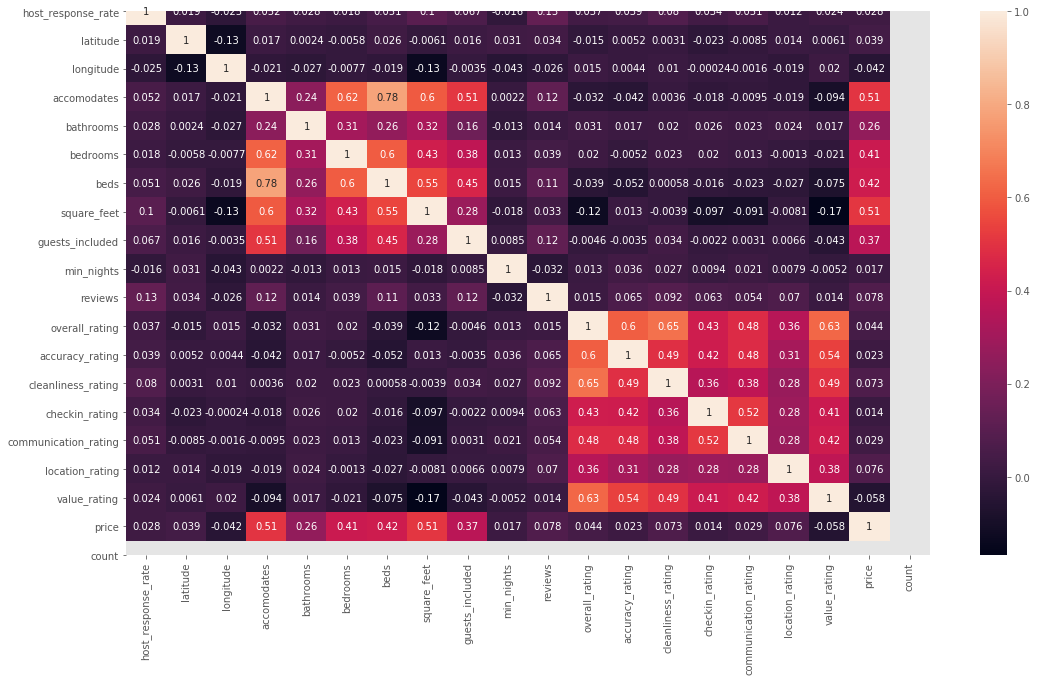

In [81]:
## Plotting the correlation matrix
plot_corr(df)

It very much makes sense that : accomodates, bathrooms, bedrooms, beds, square_feet, guest_included be are correlated to each other and are correlated to the price. The variables relative to the ratings are also well correlated , however they are not correlated to the price at all. 

In [82]:
# Plotting the average price per room type
plot_bar_graph(df,'room_type','price','Average Price per room type($)')

No surprise. An entire appartment is on average more expensive that a just private room or a shared room in an airbnb. 

In [83]:
# The average price per neighborhood
plot_bar_graph(df,'neighborhood_group','price','Average Price per neighborhood group($)')

Some neighborhoods ( Mitte,Pankow, Charlottenburg-Wilm) are on average more expensive. Mitte (means middle in german) is the center of the city, pankow is a residential area with lots of vegan cafes and organic food shops and Charlottenburg is know for its garden and monuments. However we see that the prices are on average the same all over berlin and that there is no "real" center in this city.

In [84]:
# Number of each property type
plot_bar_graph(df,'property_type','count','Population per property_type',agg='sum')

The property type is clearly imbalanced as most airbnb are apartments. It would be maybe interesting to only keep categories most represented: Apartment, condominium, house and loft. And label the other categories as "Other". This will decrease the complexity. 

In [85]:
plot_box(df,'neighborhood_group','price',colorby='neighborhood_group')

 We see that 75% of prices are below 70 euros and that the outliers fade out after 300

In [86]:
# Plotting the distribution of price range
plot_bins(df)

ImportError: cannot import name 'recode_for_categories' from 'pandas.core.arrays.categorical' (/Users/aminelarhchim/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py)

In [ ]:
# Super host vs regular hosts
plot_bar_graph(df,'is_superhost','count',title='Number of Super hosts',agg=sum)

In [ ]:
# Superhost vs regular host price
plot_bar_graph(df,'is_superhost','price','Average Price per host status($)')

On average a super host is more expensive. It could be that the added price translates the 
added trust that people have in that host; You accept to pay more for a super host because 
you're more likely to have a better stay. It could also be that on average the hosts of more 
expensive houses get to become a super hosts because of the good reviews that they have on their airbnb.

In [ ]:
# Where are the houses
df.plot.scatter(x='latitude',y='longitude',figsize=(15,15),c='price',cmap='jet')

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

In [ ]:
## Oldest and newest listings: 
print('Oldest: ',df['host_since'].min())
print('Newest: ',df['host_since'].max())

Oldest:  2009-03-22 00:00:00
Newest:  2019-05-10 00:00:00


TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

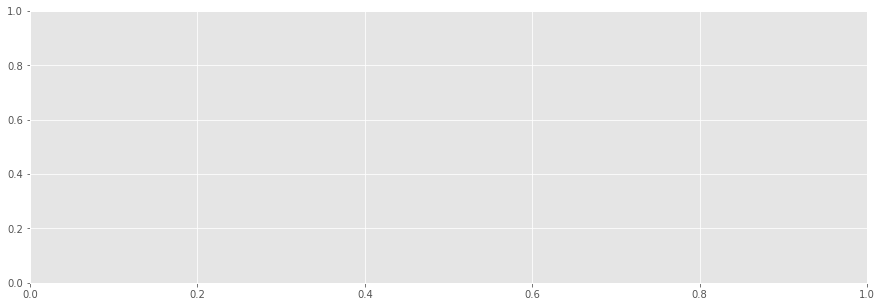

In [ ]:
plt.figure(figsize=(15,5))
df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='red')
plt.title('Berlin hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2009-03-22', '2019-05-10') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show() 

In [ ]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

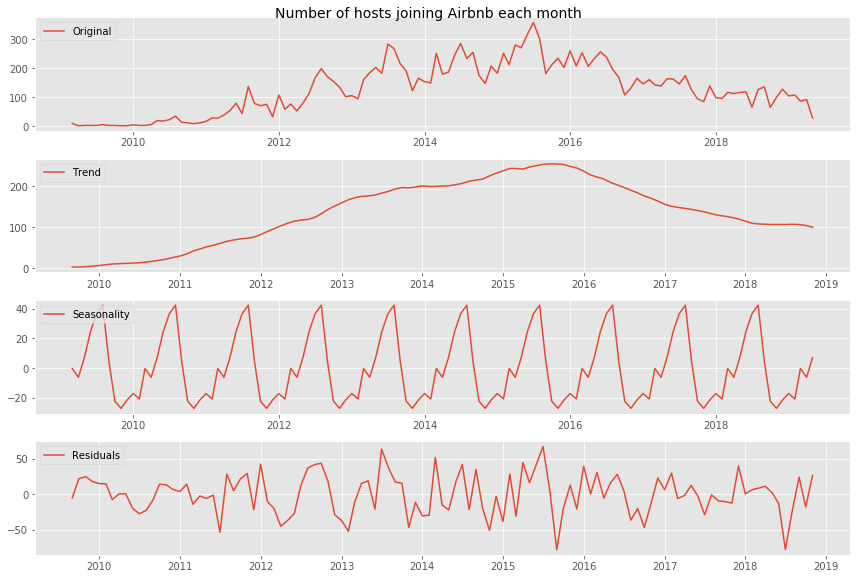

In [ ]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

There’s clear seasonality when it comes to listings entering the market.
Every year, there is a peak towards hosts joining around the middle of the year (summer), and the lowest points are the beginning and the end of each year.


In [ ]:
## Missing values per rows:
df['missing_col']=df.apply(lambda x: x.count(), axis=1)
X=[k for k in range(0,len(df.columns)-1)]
Y=[len(df['missing_col']>=i) for i in X]
d={'nb_missing_col':X,'nb_rows':Y}
df_plot=pd.DataFrame(data=d)
fig = px.bar(df_plot, x='nb_missing_col', y='nb_rows',title='Number of rows with n or more NaN columns')
fig.show()

We are only going to keep rows with less than 4 columns missing for the KNN-imputer to have enough information to draw from and at the same time keeping enough rows to train and test. But what is the best k we could chose for the KNN imputer?

### Choosing the best K for KNN imputer

In [ ]:
# Convert values to datetime
df['Host Since']=pd.to_datetime(df['Host Since']).map(dt.datetime.toordinal)
df['First Review']=pd.to_datetime(df['First Review']).map(dt.datetime.toordinal)
df['Last Review']=pd.to_datetime(df['Last Review']).map(dt.datetime.toordinal)

In [ ]:
df_impute = df[df.isnull().sum(1)<4]
df_impute=df_impute.drop(columns=['listing_id','host_id','neighborhood_group','postal_code','count','price_range'])

In [ ]:
df_impute=pd.get_dummies(df_impute,drop_first=True)
df_impute

In [ ]:
from sklearn.impute import KNNImputer
rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

def optimize_k(data, target):
    errors = []
    for k in range(1, 20, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=df.columns)
        
        X = df_imputed.drop(target, axis=1)
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds)
        errors.append({'K': k, 'RMSE': error})
        
    return errors
k_errors = optimize_k(data=df_impute, target='price')
k=[list(i.values())[0] for i in k_errors]
r=[list(i.values())[1] for i in k_errors]


plt.xlabel('k_neighbor')
plt.ylabel('rmse')
plt.plot(k,r)

The best k is then k=11

## Feature Engineering

We feel like the information from latitude and longitude could be used to determine the distance from the listings to know landamarks and busy areas of berlin. This information should be added as features. We did our research as these are the relevant coordinates of popular spots in berlin that we could find.

In [89]:
centres_berlins = [["berlin_center",52.5200,52.5200],
                   ["charlottenburg", 52.516602, 13.304105],
                   ["kreuzberg", 52.498605, 13.391799],
                   ["wedding", 52.561559, 13.35002],
                   ["mitte", 52.531677, 13.381777],
                   ["mariendorf", 52.4333316, 13.3833318],
                   ["tegel", 52.558833, 13.288437], 
                   ["tempelhof", 52.472160, 13.370287],
                   ["spandau", 52.534080, 13.181716],
                   ["schöneberg", 52.497161, 13.346865],
                   ["wilmersdorf",  52.48333, 13.31667],
                   ["biesdorf", 52.508429, 13.563317],
                   ["moabit", 52.530832, 13.345876],
                   ["britz", 52.45, 13.433333],
                   ["neukölln", 52.440771, 13.444507],
                   ["dahlem", 52.466562, 13.300082], 
                   ["tiergarten", 52.51449, 13.350091],
                   ["hellersdorf", 52.536107, 13.604973],
                   ["prenzlauer_berg", 52.550113, 13.423125], 
                   ["friedrichshain", 52.515816, 13.454293],
                   ["reinickendorf", 52.566667, 13.333333],
                   ["friedrichsfelde", 52.503664652, 13.507664636],
                   ["friedenau", 52.47133, 13.32813],
                   ["gesundbrunnen", 52.548611, 13.390278],
                   ["charlottenbourg_nord", 52.53048, 13.29371],
                   ["hansaviertel", 52.5166646, 13.33666532],
                   ["haselhorst", 52.54409, 13.23743],
                   ["gropiusstadt", 52.425, 13.46667],
                   ["westend", 52.5166646, 13.2833322],
                   ["wittenau", 52.592455, 13.329694],
                   ["zehlendorf", 52.435077, 13.260425],
                   ["lichtenberg", 52.534306, 13.502326],
                   ["pankow", 52.592879, 13.431700],
                   ["steglitz", 52.453096, 13.331171],
                   ["siemenstadt", 52.537664516, 13.257832302],
                   ["rudow", 52.402310, 13.509220],
                   ["kaulsdorf", 52.506512, 13.593946]]
def distance_from_lat_long(lat1,lon1,lat2,lon2):
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (math.sin(dlat/2))**2 + math.cos(lat1) * math.cos(lat2) * (math.sin(dlon/2))**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

def add_distance_from_hotspots_feature(df):
    for lieu in centres_berlins:                                       # Add distances 
        name_column = "distance_" + str(lieu[0])
        df[name_column] = df.apply(lambda x : distance_from_lat_long(x['Latitude'], x['Longitude'], lieu[1], lieu[2]), axis = 1)
    return df
                

In [90]:
df = add_distance_from_hotspots_feature(df)

ImportError: cannot import name 'AggFuncType' from 'pandas._typing' (/Users/aminelarhchim/opt/anaconda3/lib/python3.7/site-packages/pandas/_typing.py)

### Preprocessing (see notebook Preprocessing_final.ipynb)
Now that we understand our data better. We summarize all our processing choices in one file train_airbnb_berlin_preprocessed.csv
Will follow next a subset selection with a forward stepwise approach.

In [ ]:
# We read the cleaned csv 
df_clean=pd.read_csv('train_airbnb_berlin_Preprocessed.csv')

In [ ]:
df_clean

,host_since,host_response_rate,latitude,longitude,accomodates,bathrooms,bedrooms,beds,guests_included,min_nights,reviews,first_review,last_review,overall_rating,accuracy_rating,cleanliness_rating,checkin_rating,communication_rating,location_rating,value_rating,price,distance_berlin_center,distance_charlottenburg,distance_kreuzberg,distance_wedding,distance_mitte,distance_mariendorf,distance_tegel,distance_tempelhof,distance_spandau,distance_schöneberg,distance_wilmersdorf,distance_biesdorf,distance_moabit,distance_britz,distance_neukölln,distance_dahlem,distance_tiergarten,distance_hellersdorf,distance_prenzlauer_berg,distance_friedrichshain,distance_reinickendorf,distance_friedrichsfelde,distance_friedenau,distance_gesundbrunnen,distance_charlottenbourg_nord,distance_hansaviertel,distance_haselhorst,distance_gropiusstadt,distance_westend,distance_wittenau,distance_zehlendorf,distance_lichtenberg,distance_pankow,distance_steglitz,distance_siemenstadt,distance_rudow,distance_kaulsdorf,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,is_superhost_t,neighbourhood_Alt-HohenschÃ¶nhausen,neighbourhood_Alt-Treptow,neighbourhood_Altglienicke,neighbourhood_Baumschulenweg,neighbourhood_Biesdorf,neighbourhood_Britz,neighbourhood_Buckow,neighbourhood_Charlottenburg,neighbourhood_Dahlem,neighbourhood_Fennpfuhl,neighbourhood_FranzÃ¶sisch Buchholz,neighbourhood_Friedenau,neighbourhood_Friedrichsfelde,neighbourhood_Friedrichshagen,neighbourhood_Friedrichshain,neighbourhood_Grunewald,neighbourhood_Halensee,neighbourhood_Hansaviertel,neighbourhood_Johannisthal,neighbourhood_Karlshorst,neighbourhood_Karow,neighbourhood_Kreuzberg,neighbourhood_KÃ¶penick,neighbourhood_Lankwitz,neighbourhood_Lichtenberg,neighbourhood_Lichtenrade,neighbourhood_Lichterfelde,neighbourhood_Mahlsdorf,neighbourhood_Mariendorf,neighbourhood_Marzahn,neighbourhood_Mitte,neighbourhood_Moabit,neighbourhood_NeukÃ¶lln,neighbourhood_NiederschÃ¶neweide,neighbourhood_NiederschÃ¶nhausen,neighbourhood_Nikolassee,neighbourhood_OberschÃ¶neweide,neighbourhood_Pankow,neighbourhood_PlÃ¤nterwald,neighbourhood_Potsdamer Platz,neighbourhood_Prenzlauer Berg,neighbourhood_Rahnsdorf,neighbourhood_Reinickendorf,neighbourhood_Rudow,neighbourhood_Rummelsburg,neighbourhood_Schmargendorf,neighbourhood_SchmÃ¶ckwitz,neighbourhood_SchÃ¶neberg,neighbourhood_Spandau,neighbourhood_Steglitz,neighbourhood_Tegel,neighbourhood_Tempelhof,neighbourhood_Tiergarten,neighbourhood_Wannsee,neighbourhood_Wedding,neighbourhood_WeiÃensee,neighbourhood_Westend,neighbourhood_Wilhelmstadt,neighbourhood_Wilmersdorf,neighbourhood_Wittenau,neighbourhood_Zehlendorf,is_exact_location_t,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Condominium,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Loft,property_type_Other,property_type_Serviced apartment,property_type_Townhouse,room_type_Private room,room_type_Shared room,instant_bookable_t
0,735983.0,0.781818,52.54652,13.41792,2.0,1.0,1.0,1.0,1.0,2.0,6.0,736517.0,736549.0,100.0,10.0,10.0,10.0,10.0,9.0,10.0,26.0,5445.861668,502.032440,323.050128,300.267060,176.383932,733.616904,547.304942,510.186083,976.254289,425.477861,570.838732,638.152932,312.970675,618.064475,681.800042,690.264484,343.662639,774.720859,31.528787,245.578185,377.971134,454.522861,596.942099,115.767769,521.202675,382.327064,748.503312,796.741992,581.159063,476.584196,935.387531,356.759249,301.233086,685.484102,663.763956,981.525905,757.665468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,734965.0,0.981818,52.56512,13.42214,2.0,1.0,

### Subset Selection

In [ ]:
# Extract the target variable
y = df_clean.price

# Drop the column with the target variable 
X = df_clean.drop(['price'], axis=1)

In [ ]:
## Forward stepwise selection approach
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
features = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(features)
    features = models_fwd.loc[i]["model"].model.exog_names

AttributeError: type object 'object' has no attribute 'dtype'

In [25]:
## Results of the differents models:
print(models_fwd.loc[30,  "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.815
Model:                            OLS   Adj. R-squared (uncentered):              0.814
Method:                 Least Squares   F-statistic:                              1067.
Date:                Sun, 23 Oct 2022   Prob (F-statistic):                        0.00
Time:                        15:13:13   Log-Likelihood:                         -36434.
No. Observations:                7301   AIC:                                  7.293e+04
Df Residuals:                    7271   BIC:                                  7.313e+04
Df Model:                          30                                                  
Covariance Type:            nonrobust                                                  
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------